In [2]:
from algorithms import *
from main import *
from utils import *
from math import log
import os
from tqdm import tqdm

import grinpy as gnx

In [3]:
def non_blocking_power(Network, arm_sets, gamma, a):
    Network_result = deepcopy(Network)
    for v, w in combinations(Network.nodes, 2):
        if gnx.has_path(Network, v, w) or gnx.has_path(Network, w, v):
            try:
                for path in gnx.all_simple_paths(Network, v, w, gamma):
                    if len(path) == 1:
                        raise ValueError
                    else:
                        tmp = True
                        for u in path[1:-1]:
                            if a in arm_sets[u]:
                                tmp = False
                        if tmp:
                            raise ValueError
            except:
                Network_result.add_edge(v, w)
    return Network_result

In [4]:
def compute_invariants(Network, arm_sets, reward_avgs, K, gamma):
    # tilde{Delta]_a^v as in Yang et al., INFOCOM 2022
    Deltas = []
    for a in range(K):
        Delta = inf
        for v in Network.nodes:
            arm_set = arm_sets[v]
            max_reward = max([reward_avgs[a] for a in arm_set])
            if a in arm_set:
                delta = max_reward - reward_avgs[a]
                if Delta > delta > 0:
                    Delta = delta
        if Delta == inf:
            Delta = 0
        Deltas.append(Delta)

    # Compute theta([G^gamma]_{-a})
    Thetas, Thetas_FWA = [], []
    Network_gamma = gnx.power(Network, gamma)
    output = 0
    for a in range(K):
        Agents_a = [v for v in Network.nodes if a in arm_sets[v] and max([reward_avgs[a] for a in arm_sets[v]]) - reward_avgs[a] > 0]

        Network_gamma_a = Network_gamma.subgraph(Agents_a)
        theta = gnx.chromatic_number(gnx.complement(Network_gamma_a))  # theta(G) = chromatic_number(complement of G)
        Thetas.append(theta)

        Network_gamma_a_nonblocking = non_blocking_power(Network, arm_sets, gamma, a)
        Network_gamma_a_nonblocking = Network_gamma_a_nonblocking.subgraph(Agents_a)
        theta_FWA = gnx.chromatic_number(gnx.complement(Network_gamma_a_nonblocking))
        Thetas_FWA.append(theta_FWA)

        output += int(Deltas[a] > 0) * (theta_FWA - theta)

    return list(zip(Deltas, Thetas, Thetas_FWA)), output

In [5]:
def compute_delta(Network, arm_sets, reward_avgs, K, gamma):
    tmp, delta = compute_invariants(Network, arm_sets, reward_avgs, K, gamma)
    return delta

In [6]:
N = 30  # number of agents
K = 10  # total number of arms

tmp = np.sort(np.random.uniform(size=K))
# if not os.path.exists("deltas/means.npz"):
#     tmp = np.sort(np.random.uniform(size=K))
#     np.savez("deltas/means.npz", tmp=tmp)
# else:
#     tmp = np.load("deltas/means.npz")
#     tmp = tmp['tmp']

reward_avgs = {a: tmp[a] for a in range(K)}
total_arm_set = list(range(K))


def create_uniform_arm_sets(N, K):
    arm_sets = []  # uniformly random
    for agent in range(N):
        arm_set = []
        while len(arm_set) == 0:
            for arm in range(K):
                if np.random.rand() < 0.5:
                    arm_set.append(arm)
        arm_sets.append(arm_set)
    return arm_sets

# uniform arm distribution
arm_sets_uniform = create_uniform_arm_sets(N, K)
# if not os.path.exists(f"deltas/arm_sets_uniform.json"):
#     arm_sets_uniform = create_uniform_arm_sets(N, K, k)
#     with open(f"deltas/arm_sets_uniform.json", "w") as f:
#         json.dump(arm_sets_uniform, f)
# else:
#     with open(f"deltas/arm_sets_uniform.json", "r") as f:
#         arm_sets_uniform = json.load(f)

100%|██████████| 10/10 [14:51<00:00, 89.17s/it]


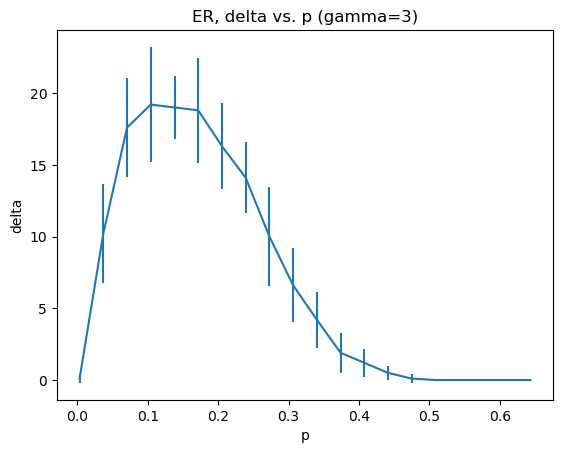

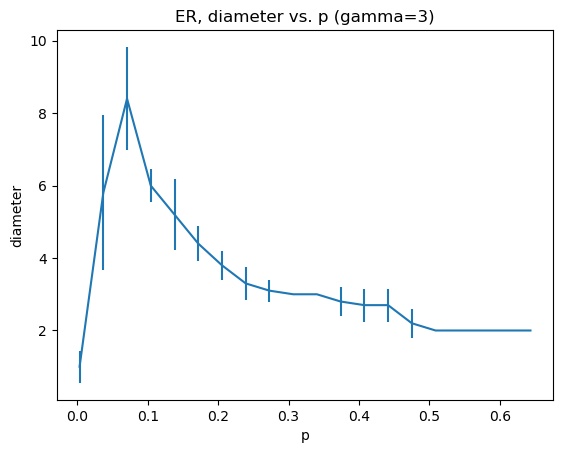

In [7]:
## delta vs. p
## create ER networks of different densities
ER_diameters, ER_deltas, ER_regret_gaps = [], [], []
u = 2023
gamma = 3
er_ps = np.linspace(0.01, 2.0, 20) / N**(0.5*(1 - (1/gamma)))
n_repeat = 10
T = int(1e2)

if not os.path.exists("deltas/vary_p/networks"):
    os.makedirs("deltas/vary_p/networks")

def F(Network):
    return compute_delta(Network, arm_sets_uniform, reward_avgs, K, gamma)

def F_regret(Network):
    Agents = [Agent(v, arm_sets_uniform[v], reward_avgs, Network, 0, 0, K) for v in range(N)]
    
    regret_gap = 0
    for _ in range(10):
        # Flooding
        problem = create_problem(Network, Agents, T, N, K, ("Flooding", None, gamma, 1.0, n_repeat))
        Group_Regrets_flooding, _, _, _ = run_ucb(problem, 1.0)
        
        # FWA
        problem = create_problem(Network, Agents, T, N, K, ("Flooding-Absorption", None, gamma, 1.0, n_repeat))
        Group_Regrets_fwa, _, _, _ = run_ucb(problem, 1.0)
        
        regret_gap += Group_Regrets_fwa[-1] - Group_Regrets_flooding[-1]
    return regret_gap
    # for _ in range(n_repeat):
    #     # Flooding
    #     problem = create_problem(Network, Agents, T, N, K, (None, "Flooding", gamma, 1.0, n_repeat))
    #     Group_Regrets_flooding, _, _, _ = run_ucb(problem, 1.0)
    #     
    #     # FWA
    #     problem = create_problem(Network, Agents, T, N, K, (None, "Flooding-Absorption", gamma, 1.0, n_repeat))
    #     Group_Regrets_fwa, _, _, _ = run_ucb(problem, 1.0)
    #     
    #     regret_gap.append(Group_Regrets_fwa[-1] - Group_Regrets_flooding[-1])
    # return regret_gap

for u in tqdm(range(2023, 2023+n_repeat)):
    # theoretical bound (compute delta)
    Networks, diameters = [], []
    for er_p in er_ps:
        Network_ER = gnx.erdos_renyi_graph(N, er_p, seed=u)
        Network_ER.name = f"ER_{er_p}"
        pos_ER = gnx.spring_layout(Network_ER)
        plot_network(Network_ER, pos_ER, parent="deltas/vary_p/networks")
        Networks.append(Network_ER)
        diameters.append(nx.diameter(Network_ER.subgraph(max(nx.connected_components(Network_ER), key=len))))
    
    with Pool() as pool:
        finals = pool.map_async(F, Networks)
        finals = finals.get()
    
    ER_deltas.append(finals)
    ER_diameters.append(diameters)
    
    # # empirical regret gap (T=500)
    # with Pool() as pool:
    #     finals = pool.map_async(F_regret, ER_Networks)
    #     finals = finals.get()
    # 
    # ER_regret_gaps.append(finals)

for i, ER_i in enumerate([ER_deltas, ER_diameters]):
# for i, ER_i in enumerate([ER_deltas, ER_regret_gaps]):
    ER_i = np.array(ER_i)
    ER_i_means = np.mean(ER_i, axis=0)
    ER_i_stds = np.std(ER_i, axis=0)
    
    if i==0:
        fname = "vary_p_deltas"
    elif i==1:
        fname = "vary_p_diameters"
    else:
        fname = "vary_p_regret_gaps"
    
    np.savez(f"deltas/{fname}.npz", ER_deltas_means=ER_i_means, ER_deltas_stds=ER_i_stds, er_ps=er_ps)
    
    plt.figure(i)
    plt.errorbar(er_ps, ER_i_means, ER_i_stds)
    if i==0:
        plt.title(f"ER, delta vs. p (gamma={gamma})")
        plt.ylabel("delta")
    elif i==1:
        plt.title(f"ER, diameter vs. p (gamma={gamma})")
        plt.ylabel("diameter")
    else:
        plt.title(f"ER, regret gap vs. p (gamma={gamma})")
        plt.ylabel("regret gap")
    plt.xlabel("p")
    plt.savefig(f"deltas/{fname}.pdf", dpi=500)
    plt.show()

In [14]:
list(nx.connected_components(Network_ER))

[{0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29}]

In [13]:
## delta vs. gamma
if not os.path.exists("deltas/vary_gamma/networks"):
    os.makedirs("deltas/vary_gamma/networks")

ER_deltas = []
u = 2023
er_p = 0.4

gammas = range(1, 10)
n_repeat = 10


for u in tqdm(range(2023, 2023+n_repeat)):
    # sample a new ER graph
    Network_ER = gnx.erdos_renyi_graph(N, er_p, seed=u)
    Network_ER.name = f"ER_{er_p}_{u}"
    pos_ER = gnx.spring_layout(Network_ER)
    plot_network(Network_ER, pos_ER, parent=f"deltas/vary_gamma/networks")
    
    def G(gamma):
        return compute_delta(Network_ER, arm_sets_uniform, reward_avgs, K, gamma)

    with Pool() as pool:
        finals = pool.map_async(G, gammas)
        finals = finals.get()
    
    ER_deltas.append(finals)

ER_deltas = np.array(ER_deltas)
ER_deltas_means = np.mean(ER_deltas, axis=0)
ER_deltas_stds = np.std(ER_deltas, axis=0)

np.savez("deltas/vary_gamma.npz", ER_deltas_means=ER_deltas_means, ER_deltas_stds=ER_deltas_stds, er_ps=er_ps)

plt.errorbar(gammas, ER_deltas_means, ER_deltas_stds, label="ER")
plt.legend()
plt.title(f"delta vs. gamma (p={er_p})")
plt.xlabel("gamma")
plt.ylabel("delta")
plt.savefig("deltas/vary_gamma.pdf", dpi=500)
plt.show()

 10%|█         | 1/10 [9:12:20<82:51:08, 33140.97s/it]

KeyboardInterrupt



In [ ]:
ps_original = np.random.uniform(size=K)

def create_nonuniform_arm_sets(N, K, k, beta):
    ps = np.exp(ps_original**beta)
    ps /= np.sum(ps)
    
    while True:
        arm_sets = [np.random.choice(range(K), size=k, replace=False, p=ps).tolist() for _ in range(N)]  # uniformly random
        # check if all arms are covered
        if set(range(K)) == set(chain.from_iterable(arm_sets)):
            break
    return arm_sets

def entropy(ps):
    return -sum([p * log(p) for p in ps])

In [ ]:
## delta vs. nonuniformity of arm distribution
## create arm distributions of different entropies by varying the temperature parameter

ER_deltas, entropies = [], []
u = 2023
er_p = 0.2
gamma = 3
Network_ER = gnx.erdos_renyi_graph(N, er_p, seed=u)
Network_ER.name = f"ER_{er_p}"
pos_ER = gnx.spring_layout(Network_ER)
plot_network(Network_ER, pos_ER, parent="deltas/vary_beta/networks")

n_repeat = 10
betas = range(1, 10)

for beta in betas:
    ps = np.exp(ps_original**beta)
    ps /= np.sum(ps)
    betas.append(entropy(ps))

def H(beta):
    arm_sets_nonuniform = create_nonuniform_arm_sets(N, K, k, beta)
    return compute_delta(Network_ER, arm_sets_nonuniform, reward_avgs, K, gamma)

for _ in tqdm(range(n_repeat)):
    ER_deltas = []
    with Pool() as pool:
        finals = pool.map_async(H, betas)
        finals = finals.get()
    
    ER_deltas.append(finals)

ER_deltas = np.array(ER_deltas)
ER_deltas_means = np.mean(ER_deltas, axis=0)
ER_deltas_stds = np.std(ER_deltas, axis=0)

sorted_idx = np.argsort(entropies)
entropies = np.array(entropies)[sorted_idx]
ER_deltas_means = ER_deltas_means[sorted_idx]
ER_deltas_stds = ER_deltas_stds[sorted_idx]

np.savez("deltas/vary_beta.npz", ER_deltas_means=ER_deltas_means, ER_deltas_stds=ER_deltas_stds, er_ps=er_ps)

plt.errorbar(entropies, ER_deltas_means, ER_deltas_stds, label="ER")
plt.legend()
plt.title(f"delta vs. beta (p={er_p}, gamma={gamma})")
plt.xlabel("entropy (nat)")
plt.ylabel("delta")
plt.savefig("deltas/vary_beta.pdf", dpi=500)
plt.show()